In [1]:
# Imports 
import os
import sys
sys.path.append("..")
os.environ["pyna_language"] = 'python'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
%matplotlib inline
from pyNA.pyna import pyna

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Inputs 
z_cb_lst = np.hstack((np.linspace(25, 250, 10), np.linspace(300, 750, 10)))

TS_cb_lst = dict()
TS_cb_lst['stca']= dict()
TS_cb_lst['stca']['V2'] = np.linspace(0.75, 1.0, 11)
TS_cb_lst['stca']['Vmax'] = np.linspace(0.4, 1.0, 25)
TS_cb_lst['a10'] = dict()
TS_cb_lst['a10']['V2'] = np.linspace(0.775, 1.0, 10)
TS_cb_lst['a10']['Vmax'] = np.linspace(0.675, 1.0, 14)

Vmax_lst = dict()
Vmax_lst['stca'] = dict()
Vmax_lst['stca']['V2'] = 197*0.51444444
Vmax_lst['stca']['Vmax'] = 250*0.51444444
Vmax_lst['a10'] = dict()
Vmax_lst['a10']['V2'] = 234.4*0.51444444
Vmax_lst['a10']['Vmax'] = 250*0.51444444

In [12]:
# Load trajectories and engines 
stcb_sweeps = dict()
ptcb_sweeps = dict()
idx_stcb_control = dict()
stcb_control = dict()
traj = dict()
engine = dict()

for ac_name in ['stca', 'a10']:
    
    stcb_sweeps[ac_name] = dict()
    ptcb_sweeps[ac_name] = dict()
    idx_stcb_control[ac_name] = dict()
    stcb_control[ac_name] = dict()
    traj[ac_name] = dict()
    engine[ac_name] = dict()
    
    for case in ['V2', 'Vmax']:

        # Load STCB sweeps
        stcb_sweeps[ac_name][case] = dict()
        stcb_sweeps[ac_name][case]['sideline'] = np.load('../cases/'+ac_name+'/output/STCB/' + case + '/sweeps/epnl_sideline.npy') 
        stcb_sweeps[ac_name][case]['flyover']  = np.load('../cases/'+ac_name+'/output/STCB/' + case + '/sweeps/epnl_flyover.npy') 
        stcb_sweeps[ac_name][case]['lateral']  = np.max(stcb_sweeps[ac_name][case]['sideline'][:,:,20:], axis=2)
        stcb_sweeps[ac_name][case]['takeoff']  = stcb_sweeps[ac_name][case]['lateral'] + stcb_sweeps[ac_name][case]['flyover'] 

        # Load PTCB sweeps
        ptcb_sweeps[ac_name][case] = dict()
#         if ac_name == 'stca' and case in ['V2', 'Vmax']:
        ptcb_sweeps[ac_name][case]['sideline'] = np.load('../cases/'+ac_name+'/output/PTCB/' + case + '/epnl_sideline.npy') 
        ptcb_sweeps[ac_name][case]['flyover']  = np.load('../cases/'+ac_name+'/output/PTCB/' + case + '/epnl_flyover.npy') 
        ptcb_sweeps[ac_name][case]['lateral']  = np.max(ptcb_sweeps[ac_name][case]['sideline'][20:])
        ptcb_sweeps[ac_name][case]['takeoff']  = ptcb_sweeps[ac_name][case]['lateral'] + ptcb_sweeps[ac_name][case]['flyover']
        
        # Get index of key STCB controls
        idx_stcb_control[ac_name][case] = dict()
        epnl_sub = np.copy(stcb_sweeps[ac_name][case]['takeoff'])
        epnl_sub[:10, :] = 1000*np.ones((10, epnl_sub.shape[1]))
        idx_stcb_control[ac_name][case]['std'] = np.unravel_index(np.argmin(epnl_sub, axis=None), epnl_sub.shape)
        epnl_sub = stcb_sweeps[ac_name][case]['takeoff'][:10, :]
        idx_stcb_control[ac_name][case]['adv'] = np.unravel_index(np.argmin(epnl_sub, axis=None), epnl_sub.shape)

        # Get key STCB controls
        stcb_control[ac_name][case] = dict()
        stcb_control[ac_name][case]['z_cb'] = dict()
        stcb_control[ac_name][case]['TS_cb'] = dict()
        stcb_control[ac_name][case]['z_cb']['std'] = z_cb_lst[idx_stcb_control[ac_name][case]['std'][0]]
        stcb_control[ac_name][case]['z_cb']['adv'] = z_cb_lst[idx_stcb_control[ac_name][case]['adv'][0]]
        stcb_control[ac_name][case]['TS_cb']['std'] = TS_cb_lst[ac_name][case][idx_stcb_control[ac_name][case]['std'][1]]
        stcb_control[ac_name][case]['TS_cb']['adv'] = TS_cb_lst[ac_name][case][idx_stcb_control[ac_name][case]['adv'][1]]
        
        # Get trajectories
        traj[ac_name][case] = dict()
        traj[ac_name][case]['std'] = pd.read_csv('../cases/'+ac_name+'/trajectory/STCB/'+case+'/trajectory_'+ac_name+'_'+str(stcb_control[ac_name][case]['z_cb']['std'])+'_'+str(np.round(stcb_control[ac_name][case]['TS_cb']['std'], 3))+'.csv')
        traj[ac_name][case]['adv'] = pd.read_csv('../cases/'+ac_name+'/trajectory/STCB/'+case+'/trajectory_'+ac_name+'_'+str(stcb_control[ac_name][case]['z_cb']['adv'])+'_'+str(np.round(stcb_control[ac_name][case]['TS_cb']['adv'], 3))+'.csv')
        traj[ac_name][case]['ptcb'] = pd.read_csv('../cases/'+ac_name+'/trajectory/PTCB/'+case+'/trajectory_'+ac_name+'_ptcb_'+case+'.csv')

        # Get trajectories
        engine[ac_name][case] = dict()
        engine[ac_name][case]['std'] = pd.read_csv('../cases/'+ac_name+'/engine/STCB/'+case+'/engine_'+ac_name+'_'+str(stcb_control[ac_name][case]['z_cb']['std'])+'_'+str(np.round(stcb_control[ac_name][case]['TS_cb']['std'], 3))+'.csv')
        engine[ac_name][case]['adv'] = pd.read_csv('../cases/'+ac_name+'/engine/STCB/'+case+'/engine_'+ac_name+'_'+str(stcb_control[ac_name][case]['z_cb']['adv'])+'_'+str(np.round(stcb_control[ac_name][case]['TS_cb']['adv'], 3))+'.csv')
        engine[ac_name][case]['ptcb'] = pd.read_csv('../cases/'+ac_name+'/engine/PTCB/'+case+'/engine_'+ac_name+'_ptcb_'+case+'.csv')



In [211]:
# Compute NOx emissions certification cycles
def compute_EI(T3, P3):
    a = 6.25528852e-08
    b = -1.17064467e-04
    c = 7.36953400e-02
    d = -1.50392850e+01
    EI = (P3 / 1000.) ** 0.4 * (a * T3 ** 3 + b * T3 ** 2 + c * T3 + d)
    
    return EI

cert = dict()
for ac_name in ['stca', 'a10']:

    cert[ac_name] = dict()
    
    pyna_settings = pyna.load_settings(case_name=ac_name)
    pyna_settings.ac_name = ac_name
    pyna_settings.engine_file_name = 'engine_deck_'+ac_name+'.csv'
    py = pyna(pyna_settings)
    py.engine.load_deck(py.settings)

    T3_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['Tti_c'])
    P3_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['Pti_c'])
    Wf_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['W_f'])
    
    for i, case in enumerate(['subsonic', 'supersonic']):
        cert[ac_name][case] = dict()

        if case == 'subsonic':
            cert[ac_name][case]['t'] = 2.2*60
            cert[ac_name][case]['t_TO'] = 0.7*60
            cert[ac_name][case]['TS'] = 0.85
        elif case == 'supersonic':
            cert[ac_name][case]['t'] = 2.0*60
            cert[ac_name][case]['t_TO'] = 1.2*60
            cert[ac_name][case]['TS'] = 0.65
            
        cert[ac_name][case]['Tt3'] = T3_interp((0, 0, TS_lst[i]))
        cert[ac_name][case]['Pt3'] = P3_interp((0, 0, TS_lst[i]))
        cert[ac_name][case]['W_f'] = Wf_interp((0, 0, TS_lst[i]))
        cert[ac_name][case]['EI'] = compute_EI(cert[ac_name][case]['Tt3'], cert[ac_name][case]['Pt3'])
        cert[ac_name][case]['m_nox'] = cert[ac_name][case]['t']*cert[ac_name][case]['EI']*cert[ac_name][case]['W_f']
        
        Tt3_TO = T3_interp((0, 0, 1))
        Pt3_TO = P3_interp((0, 0, 1))
        cert[ac_name][case]['EI_TO'] = compute_EI(Tt3_TO, Pt3_TO)


In [246]:
# Compute emissions for trajectories
m_nox = dict()
TS_avg = dict()
t_climb = dict()

tEINOx_timeseries = dict()
EINOx_timeseries = dict()

for ac_name in ['stca', 'a10']:

    m_nox[ac_name] = dict()
    TS_avg[ac_name] = dict()
    t_climb[ac_name] = dict()
    
    EINOx_timeseries[ac_name] = dict()
    tEINOx_timeseries[ac_name] = dict()
    
    pyna_settings = pyna.load_settings(case_name=ac_name)
    pyna_settings.ac_name = ac_name
    pyna_settings.engine_file_name = 'engine_deck_'+ac_name+'.csv'
    py = pyna(pyna_settings)
    py.engine.load_deck(py.settings)
    T3_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['Tti_c'])
    P3_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['Pti_c'])
    Wf_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['W_f'])

    for case in ['V2', 'Vmax']:
        m_nox[ac_name][case]  = np.zeros(3)
        TS_avg[ac_name][case] = np.zeros(3)
        t_climb[ac_name][case] = np.zeros(3)

        EINOx_timeseries[ac_name][case] = dict()
        tEINOx_timeseries[ac_name][case] = dict()
        
        for j,t_name in enumerate(['std', 'adv', 'ptcb']):
            z  = traj[ac_name][case][t_name]['Z [m]']
            M0 = traj[ac_name][case][t_name]['M_0 [-]']
            TS = traj[ac_name][case][t_name]['TS [-]']

            Tt3 = np.zeros(np.size(z))
            Pt3 = np.zeros(np.size(z))
            Wf = np.zeros(np.size(z))
            EINOx = np.zeros(np.size(z))
            mdot_NOx = np.zeros(np.size(z))
            
            for i in np.arange(np.size(z)):
                Tt3[i] = T3_interp((np.max((0,z[i])), M0[i], TS[i]))
                Pt3[i] = P3_interp((np.max((0,z[i])), M0[i], TS[i]))
                Wf[i] =  Wf_interp((np.max((0,z[i])), M0[i], TS[i]))
                EINOx[i] = compute_EI(Tt3[i], Pt3[i])
                mdot_NOx[i] = EINOx[i] * Wf[i]

            # Compute emissions between 35 and 3000ft
            i_co = np.where((35*0.3048<=traj[ac_name][case][t_name]['Z [m]'].values)*(traj[ac_name][case][t_name]['Z [m]'].values<=3000*0.3048))[0]

            m_nox[ac_name][case][j] = np.trapz(mdot_NOx[i_co], traj[ac_name][case][t_name]['t_source [s]'][i_co])
            t_climb[ac_name][case][j] = traj[ac_name][case][t_name]['t_source [s]'][i_co].values[-1]-traj[ac_name][case][t_name]['t_source [s]'][i_co].values[0]
            TS_avg[ac_name][case][j] = np.mean(traj[ac_name][case][t_name]['TS [-]'][i_co])
            
            tEINOx_timeseries[ac_name][case][t_name] = traj[ac_name][case][t_name]['t_source [s]'][np.where(traj[ac_name][case][t_name]['Z [m]'].values<=3000*0.3048)[0]]
            EINOx_timeseries[ac_name][case][t_name] = EINOx[np.where(traj[ac_name][case][t_name]['Z [m]'].values<=3000*0.3048)[0]]
            

In [217]:
def plot_time_in_mode_TS_avg(ac_name, t_climb, TS_avg, cert):
    
    fig, ax = plt.subplots(1,2, figsize=(15,3.))

    colors = ['k', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    if ac_name == 'stca':
        cb_alt = 260        
    elif ac_name == 'a10':
        cb_alt = 210
    
    for i, case in enumerate(['V2', 'Vmax']):
        if i == 0:
            bar_t = ax[0].bar([0.15, 1, 2.2, 3.2, 4.2], np.hstack((cert['subsonic']['TS'], cert['supersonic']['TS'], TS_avg[case])), width=0.3, color=colors, hatch=hatch[i])
        elif i == 1:
            bar_t = ax[0].bar([0.15, 1, 2.6, 3.6, 4.6], np.hstack((cert['subsonic']['TS'], cert['supersonic']['TS'], TS_avg[case])), width=0.3, color=colors, hatch=hatch[i])
            
        if i == 1:
            ax[i].fill_between([18,19], [8,8], [9,9], color='tab:blue', label='STCB ($z_{cb} \geq$ '+str(cb_alt)+'m)', hatch=hatch[i])
            ax[i].fill_between([18,19], [8,8], [9,9], color='tab:orange', label='STCB ($z_{cb} <$ '+str(cb_alt)+'m)', hatch=hatch[i])
            ax[i].fill_between([18,19], [8,8], [9,9], color='tab:green', label='PTCB', hatch=hatch[i])
            ax[i].fill_between([18,19], [8,8], [9,9], color='white', label='', hatch=hatch[i])
            ax[i].fill_between([18,19], [8,8], [9,9], facecolor='w', edgecolor="k", label='$V_{max}$ = $V_2$ + 20 kts', hatch='')
            ax[i].fill_between([18,19], [8,8], [9,9], facecolor='w', edgecolor="k", label='$V_{max}$ = 250 kts', hatch='//')


    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].annotate(xy=(-0.3, 0.1), s='Subsonic', rotation=90, color='k', fontsize=18)
    ax[0].annotate(xy=( 0.575, 0.1), s='Supersonic', rotation=90, color='k', fontsize=18)
    ax[0].set_xlim([-0.8, 5])
    ax[0].set_ylim([0,1])
    ax[0].set_xticks([0.4, 3.4])
    ax[0].set_xticklabels([])
    ax[0].set_ylabel(r'TS [-]')
    
    for i, case in enumerate(['V2', 'Vmax']):
        if i == 0:
            bar_t = ax[1].bar([0.15, 1, 2.2, 3.2, 4.2], np.hstack((cert['subsonic']['t'], cert['supersonic']['t'], t_climb[case]))/cert['supersonic']['t'], width=0.3, color=colors, hatch=hatch[i])
        elif i == 1:
            bar_t = ax[1].bar([0.15, 1, 2.6, 3.6, 4.6], np.hstack((cert['subsonic']['t'], cert['supersonic']['t'], t_climb[case]))/cert['supersonic']['t'], width=0.3, color=colors, hatch=hatch[i])

    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].annotate(xy=(-0.3, 0.1), s='Subsonic', rotation=90, color='k', fontsize=18)
    ax[1].annotate(xy=( 0.575, 0.1), s='Supersonic', rotation=90, color='k', fontsize=18)
    ax[1].set_xlim([-0.8, 5])
    ax[1].set_ylim([0,1.2])
    ax[1].set_xticks([0.4, 3.4])
    ax[1].set_xticklabels([])
    ax[1].set_ylabel(r'$\frac{t_{climb}}{t_{climb, supersonic}}$ [-]')
    
    ax[1].legend(loc='lower left', bbox_to_anchor=(1.0, 0.0), ncol=1, borderaxespad=0, frameon=False)
    
    plt.subplots_adjust(wspace=0.35)

def plot_cumulative_NOx_emissions_comparison(ac_name, m_nox, cert):

    fig, ax = plt.subplots(1,1, figsize=(10,3.5))

    colors = ['k', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    if ac_name == 'stca':
        cb_alt = 260        
    elif ac_name == 'a10':
        cb_alt = 210
    
    for i, case in enumerate(['V2', 'Vmax']):
        if i == 0:
            bar_t = ax.bar([0, 0.7, 2.2, 3.2, 4.2], np.hstack((cert['subsonic']['m_nox'], cert['supersonic']['m_nox'], m_nox[case]))/cert['supersonic']['m_nox'], width=0.3, color=colors, hatch=hatch[i])
        elif i == 1:
            bar_t = ax.bar([0, 0.7, 2.6, 3.6, 4.6], np.hstack((cert['subsonic']['m_nox'], cert['supersonic']['m_nox'], m_nox[case]))/cert['supersonic']['m_nox'], width=0.3, color=colors, hatch=hatch[i])

        if i == 0:
            ax.fill_between([18,19], [8,8], [9,9], color='tab:blue',   label='STCB ($z_{cb} \geq$ '+str(cb_alt)+'m)', hatch=hatch[i])
            ax.fill_between([18,19], [8,8], [9,9], color='tab:orange', label='STCB ($z_{cb} <$ '+str(cb_alt)+'m)', hatch=hatch[i])
            ax.fill_between([18,19], [8,8], [9,9], color='tab:green',  label='PTCB', hatch=hatch[i])
            ax.fill_between([18,19], [8,8], [9,9], color='white',      label='', hatch=hatch[i])

    ax.set_xlim([-1, 5.5])
    ax.set_ylim([-0.0, 2.0])

    ax.set_xticks([0, 0.7, 2, 3, 4, 5])
    ax.set_xticks([0.2, 3.4])
    ax.set_xticklabels(['Emissions LTO cycle\nclimb-out emissions', 'Cumulative climb-out\nemissions (z$\in$[35,3000] ft)'])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.fill_between([18,19], [8,8], [9,9], facecolor='w', edgecolor="k", label='$V_{max}$ = $V_2$ + 20 kts', hatch='')
    ax.fill_between([18,19], [8,8], [9,9], facecolor='w', edgecolor="k", label='$V_{max}$ = 250 kts', hatch='//')

    ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0), ncol=1, borderaxespad=0, frameon=False)

    ax.set_ylabel(r'$\frac{m_{NO_x}}{m_{{NO_x}, supersonic\ cert.}}$', fontsize=22)

    ax.annotate(xy=(-0.35, 0.1), s='Subsonic', rotation=90, color='k', fontsize=18)
    ax.annotate(xy=( 0.35, 0.1), s='Supersonic', rotation=90, color='k', fontsize=18)
    

In [315]:
def plot_instantaneous_EI_NOx(ac_name, tEINOx_timeseries, EINOx_timeseries, cert):
    
    fig, ax = plt.subplots(1, 2, figsize=(15,3))

    colors = ['k', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    if ac_name == 'stca':
        cb_alt = 260        
    elif ac_name == 'a10':
        cb_alt = 210

    ax[0].plot([0, cert['subsonic']['t_TO'], cert['subsonic']['t_TO'], cert['subsonic']['t_TO']+cert['subsonic']['t']], [cert['subsonic']['EI_TO'], cert['subsonic']['EI_TO'], cert['subsonic']['EI'], cert['subsonic']['EI']], 'k-', markersize=6)
    ax[0].plot([0, cert['supersonic']['t_TO'], cert['supersonic']['t_TO'], cert['supersonic']['t_TO']+cert['supersonic']['t']], [cert['supersonic']['EI_TO'], cert['supersonic']['EI_TO'], cert['supersonic']['EI'], cert['supersonic']['EI']], 'k--', markersize=8)
    ax[1].plot([0, cert['subsonic']['t_TO'], cert['subsonic']['t_TO'], cert['subsonic']['t_TO']+cert['subsonic']['t']], [cert['subsonic']['EI_TO'], cert['subsonic']['EI_TO'], cert['subsonic']['EI'], cert['subsonic']['EI']], 'k-', markersize=6, label='Subsonic cert.')
    ax[1].plot([0, cert['supersonic']['t_TO'], cert['supersonic']['t_TO'], cert['supersonic']['t_TO']+cert['supersonic']['t']], [cert['supersonic']['EI_TO'], cert['supersonic']['EI_TO'], cert['supersonic']['EI'], cert['supersonic']['EI']], 'k--', markersize=8, label='Supersonic cert.')
    
    linestyles = ['-', '--']
    
    labels=['STCB ($z_{cb} \geq$ '+str(cb_alt)+'m)', 'STCB ($z_{cb} <$ '+str(cb_alt)+'m)', 'PTCB']
    
    for j, case in enumerate(['V2', 'Vmax']):
        for k,t_name in enumerate(['std', 'adv', 'ptcb']):
            ax[j].plot(tEINOx_timeseries[case][t_name], EINOx_timeseries[case][t_name], color=colors[k+2], label=labels[k])

        ax[j].set_xlabel('Time from brake release [s]')
        ax[0].set_ylabel('$EINO_x$ [g/kg fuel]')

        if ac_name == 'stca':
            ax[j].set_ylim([8, 18])
            ax[j].set_yticks([8, 10, 12, 14, 16, 18])
            ax[0].set_title('$V_2$+20 kts = 197 kts')
            ax[1].set_title('$V_{max}$ = 250 kts')
        elif ac_name == 'a10':
            ax[j].set_ylim([6, 10])
            ax[j].set_yticks([6, 7, 8, 9, 10])
            ax[0].set_title('$V_2$+20 kts = 234 kts')
            ax[1].set_title('$V_{max}$ = 250 kts')

        
    plt.legend(loc='lower left', bbox_to_anchor=(1., 0.0), frameon=False)
            
    plt.subplots_adjust(wspace=0.15)

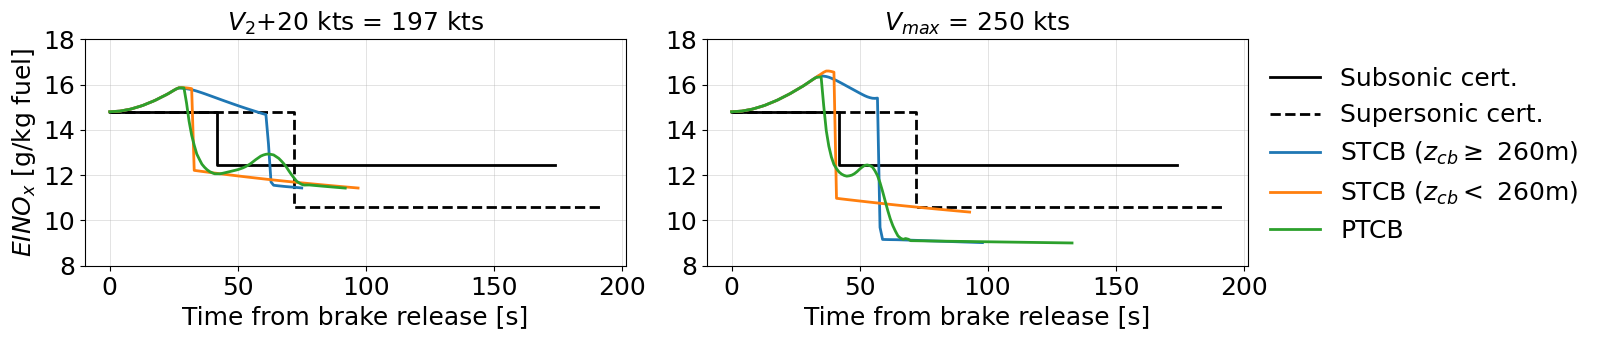

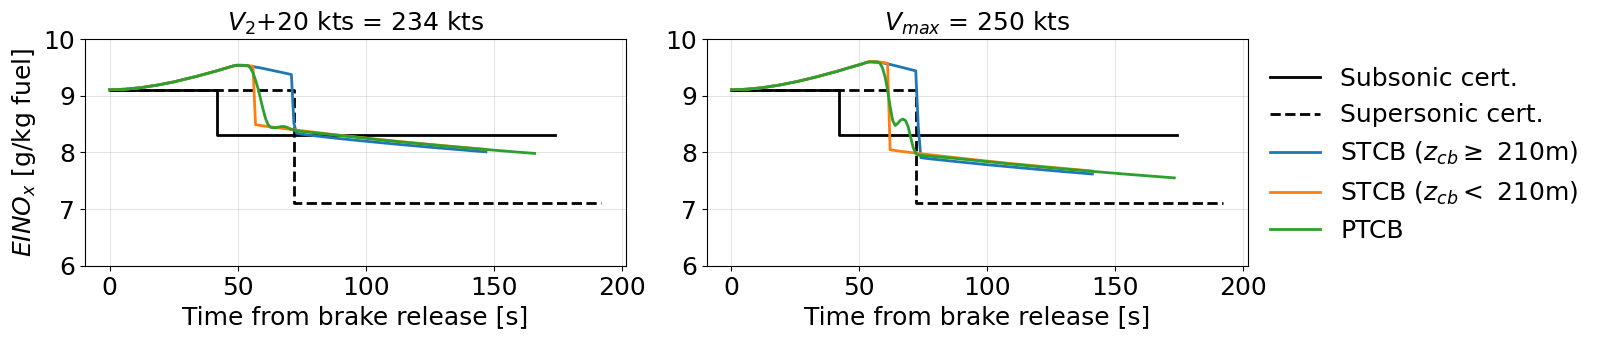

In [316]:
plot_instantaneous_EI_NOx('stca', tEINOx_timeseries['stca'], EINOx_timeseries['stca'], cert['stca'])
plot_instantaneous_EI_NOx('a10', tEINOx_timeseries['a10'], EINOx_timeseries['a10'], cert['a10'])

--- TS ---
STD STCA:  20.867 %
STD A10:   6.345 %
--- time ---
STD STCA:  25.043 %
STD A10:   13.051 %


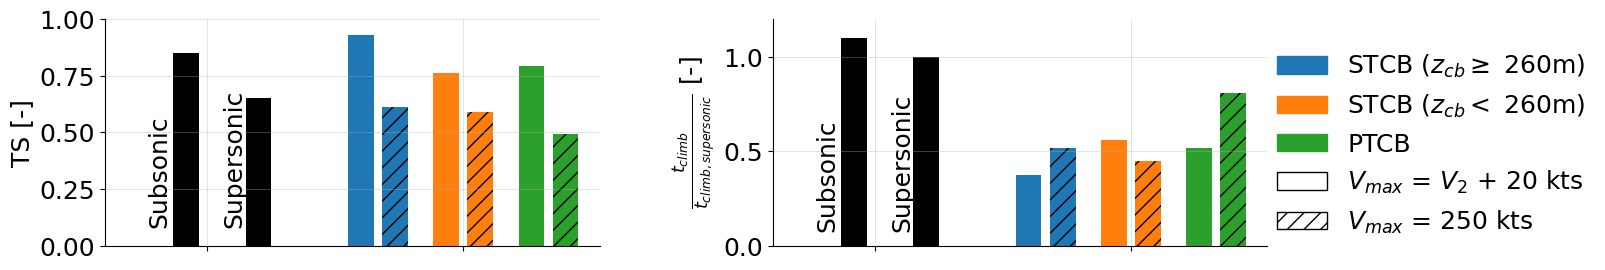

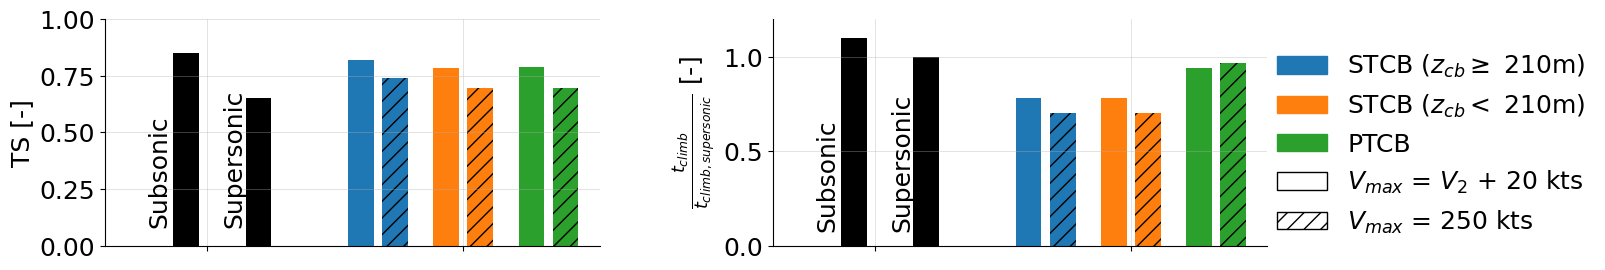

In [203]:
# Compare time in mode and average thrust-setting
plot_time_in_mode_TS_avg('stca', t_climb['stca'], TS_avg['stca'], cert['stca'])
plot_time_in_mode_TS_avg('a10', t_climb['a10'], TS_avg['a10'], cert['a10'])

print('--- TS ---')
print('STD STCA: ', np.round(np.std(np.hstack((TS_avg['stca']['V2'], TS_avg['stca']['Vmax'])))/np.mean(np.hstack((TS_avg['stca']['V2'], TS_avg['stca']['Vmax'])))*100, 3), '%')
print('STD A10:  ', np.round(np.std(np.hstack((TS_avg['a10']['V2'], TS_avg['a10']['Vmax'])))/np.mean(np.hstack((TS_avg['a10']['V2'], TS_avg['a10']['Vmax'])))*100, 3), '%')

print('--- time ---')
print('STD STCA: ', np.round(np.std(np.hstack((t_climb['stca']['V2'], t_climb['stca']['Vmax'])))/np.mean(np.hstack((t_climb['stca']['V2'], t_climb['stca']['Vmax'])))*100, 3), '%')
print('STD A10:  ', np.round(np.std(np.hstack((t_climb['a10']['V2'], t_climb['a10']['Vmax'])))/np.mean(np.hstack((t_climb['a10']['V2'], t_climb['a10']['Vmax'])))*100, 3), '%')

STD STCA:  15.817 %
STD A10:   13.81 %


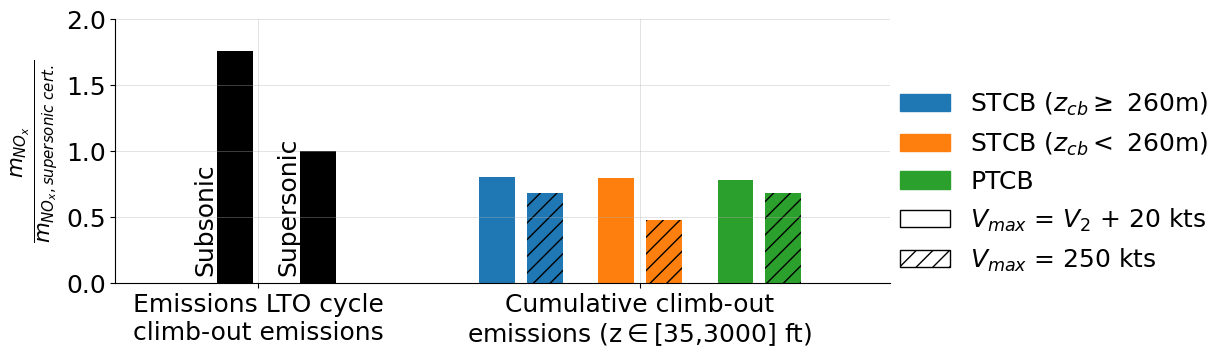

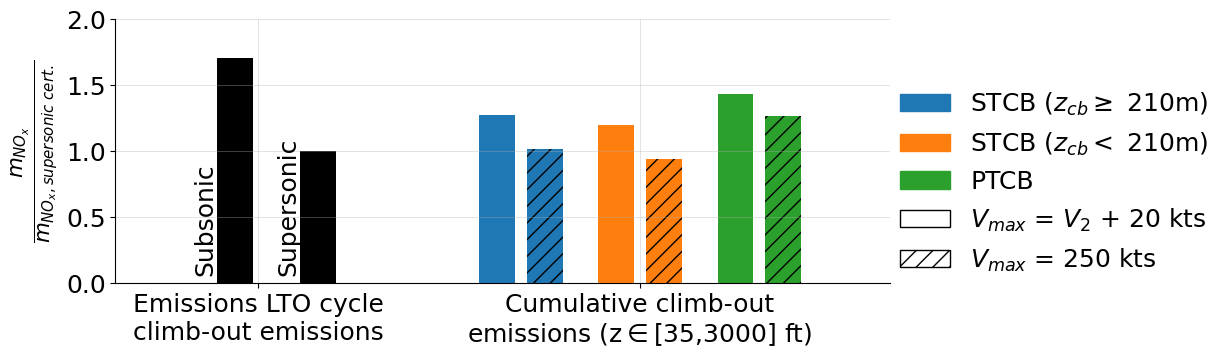

In [122]:
# Compare cumulative NOx 
plot_cumulative_NOx_emissions_comparison('stca', m_nox['stca'], cert['stca'])
plot_cumulative_NOx_emissions_comparison('a10', m_nox['a10'], cert['a10'])

print('STD STCA: ', np.round(np.std(np.hstack((m_nox['stca']['V2'], m_nox['stca']['Vmax'])))/np.mean(np.hstack((m_nox['stca']['V2'], m_nox['stca']['Vmax'])))*100, 3), '%')
print('STD A10:  ', np.round(np.std(np.hstack((m_nox['a10']['V2'], m_nox['a10']['Vmax'])))/np.mean(np.hstack((m_nox['a10']['V2'], m_nox['a10']['Vmax'])))*100, 3), '%')

In [42]:
def plot_figure(TS_avg, t_climb, m_nox):
    hatch = ['', '//']

    fig, ax = plt.subplots(1,1, figsize=(15,3.5))
    plt.style.use('../utils/plot.mplstyle')

    for i, case in enumerate(['V2', 'Vmax']):

        colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

        bar_l = ax.bar(np.linspace(-0.3, +0.3, 3)+0+0.09*i-0.04, TS_avg[case], width=0.08, color=colors, hatch=hatch[i])
        bar_f = ax.bar(np.linspace(-0.3, +0.3, 3)+1+0.09*i-0.04, t_climb[case]/120, width=0.08, color=colors, hatch=hatch[i])
        bar_t = ax.bar(np.linspace(-0.3, +0.3, 3)+2+0.09*i-0.04, m_nox[case]/1000, width=0.08, color=colors, hatch=hatch[i])

        ax.set_xticks(np.arange(3))
        ax.set_xticklabels(['$TS_{avg}$', r'$\frac{t_{climb}}{t_{supersonic}}$', 'n'])

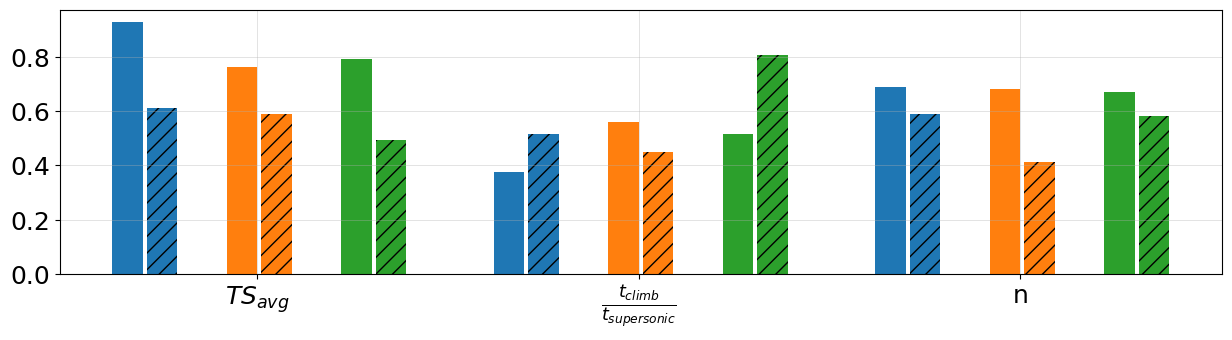

In [43]:
plot_figure(TS_avg['stca'], t_climb['stca'], m_nox['stca'])